## Aprendizado Profundo para Processamento de Linguagem Natural
### TP1 - Word Embeddings

#### Aluno: João Antonio Oliveira Pedrosa
#### Matrícula: 2019006752

#### Preparing environment

This cell prepares the environment with everything that is needed to run the notebook.

In [73]:
# !pip install contractions
# !pip install nltk
# !pip install tqdm
# !pip install gensim
# !pip install pandas
# !pip install seaborn
# !pip install matplotlib

# # Download the text corpus
# corpus_url = "https://mattmahoney.net/dc/text8.zip"
# corpus_file = "text8.zip"
# urllib.request.urlretrieve(corpus_url, corpus_file)

# # Download the analogy questions file
# questions_url = "https://github.com/nicholas-leonard/word2vec/raw/master/questions-words.txt"
# questions_file = "questions-words.txt"
# urllib.request.urlretrieve(questions_url, questions_file)

# # Extract the text corpus
# with zipfile.ZipFile(corpus_file, 'r') as zip_ref:
#     zip_ref.extractall()

#### Imports

In [72]:
import urllib.request
import zipfile
import gensim
import string
import itertools
import pandas as pd
from tqdm import tqdm
from nltk.corpus import stopwords
import contractions
from concurrent.futures import ThreadPoolExecutor
import seaborn as sns
import matplotlib.pyplot as plt

#### Defining preprocessing functions

* preprocess_basic
    
    This function is here to assure that we won't have any mismatches due to capitalizing and also to transform a line of text into words. This function will always be used in all texts since in the training corpus all words are already on lower case.
    
* preprocess_stop_words

    This function takes a list of words as input and removes common stop words from the list. Stop words are words that occur frequently in the English language but typically do not carry significant semantic meaning (e.g., "the," "and," "of"). By removing stop words, the function helps reduce noise in the text data and focuses on words that are more likely to contain valuable semantic information. This preprocessing step is relevant for the embedding task because it improves the quality of the word vectors by filtering out words that do not contribute to the modeling of word relationships.

* preprocess_contractions

    This function expands contractions in a list of words. Contractions are combinations of two words, where one or more letters are omitted, such as "don't" for "do not" or "can't" for "cannot." Expanding contractions helps standardize the text data and ensures that words are represented in their full, uncontracted forms. This is pertinent for the embedding task because it helps the model capture the semantic relationships between words more accurately. When contractions are expanded, the model has access to the full words and can better understand the underlying language structure and semantics.

In [28]:
def preprocess_basic(text):
    words = gensim.utils.simple_preprocess(text)
    words = [word.lower() for word in words]
    
    return words

# I'm caching stuff :)
filtered_words = []
def preprocess_stop_words(word_list):
    global filtered_words
    print("Removing Stopwords...")
    if filtered_words:
        return filtered_words
    stop_words = set(stopwords.words("english"))
    filtered_words = [word for word in word_list if word.lower() not in stop_words]
    return filtered_words

expanded_words = []
def preprocess_contractions(word_list):
    global expanded_words
    print("Expanding Contractions...")
    if expanded_words:
        return expanded_words
    for word in word_list:
        expanded_words.extend(contractions.fix(word).split())
    return expanded_words

#### Defining training function

This function trains a Word2Vec model. It operates on a provided text corpus, and receives hyperparameters and preprocessing choices. The key inputs include:

- `corpus`: The text data to be used for training word embeddings.
- `training_size`: An integer representing the size of the training data subset.
- `window_size`: An integer defining the context window size for word co-occurrence.
- `model_type`: A string indicating the model type, either "CBOW" (Continuous Bag of Words) or "Skip-Gram."
- `remove_stopwords`: A boolean flag for removing common stopwords.
- `expand_contractions`: A boolean flag for expanding contractions.

The function executes the following tasks:

1. Preprocesses the input corpus based on the provided preprocessing options, enhancing data quality.
2. Trains a Word2Vec model using Gensim and the specified hyperparameters.
3. Returns the trained Word2Vec model.

In [57]:
def train_word2vec_model(corpus, min_count=1, window_size=10, model_type="Skip-Gram", remove_stopwords=True, expand_contractions=True):
    if expand_contractions:
        corpus = preprocess_contractions(corpus)
        
    if remove_stopwords:
        corpus = preprocess_stop_words(corpus)
    
    print("Training...")
    model = gensim.models.Word2Vec(sentences=[corpus], sg=(1 if model_type == "Skip-Gram" else 0),
                                   vector_size=100, window=window_size, min_count=min_count, workers=8)

    return model

#### Defining evaluation function

This function assesses the quality of word embeddings by testing the model's ability to complete word analogies. It calculates various distance-based metrics between predicted and expected words.

The function iterates through the analogy questions, calculates the cosine distances between predicted and expected words, and aggregates statistics to assess the model's performance. If a word is not found in the model's vocabulary, it is skipped.

I'm also parallelizing it to speed up the experiments.

Parameters:

- `model`: The Word2Vec model to be evaluated.

- `analogy_questions`: A list of analogy questions, where each question is a tuple. Each question contains four words: a, b, c, and expected, representing the relationship "a is to b as c is to expected."

Returns:

- `mean_distance`: The mean cosine distance between predicted and expected words.

- `median_distance`: The median cosine distance between predicted and expected words.

- `max_distance`: The maximum cosine distance between predicted and expected words.

- `min_distance`: The minimum cosine distance between predicted and expected words.

In [61]:
def calculate_distance(question, model, distances):
    try:
        a, b, c, expected = question
        predicted = model.wv.most_similar(positive=[b, c], negative=[a])[0][0]
        distance = model.wv.similarity(predicted, expected)
        distances.append(abs(distance))
    except KeyError:
        distances.append(1)  # According to my previous experiments this is a good value to consider for a failure since it's an upper bound of the maximum distance I got in most
        pass

def evaluate_analogies(model, analogy_questions):
    """
    Parameters:
    - model: The Word2Vec or word embeddings model to be evaluated.
    - analogy_questions: A list of analogy questions, where each question is represented as a tuple (section, question).
      Each question contains four words: a, b, c, and expected, representing the relationship "a is to b as c is to expected."

    Returns:
    - mean_distance: The mean cosine distance between predicted and expected words.
    - median_distance: The median cosine distance between predicted and expected words.
    - max_distance: The maximum cosine distance between predicted and expected words.
    - min_distance: The minimum cosine distance between predicted and expected words.
    """
    distances = []

    with ThreadPoolExecutor(max_workers=8) as executor:
        futures = [executor.submit(calculate_distance, question, model, distances) for question in analogy_questions]
        # Wait for all tasks to complete
        for future in tqdm(futures, total=len(futures), desc="Evaluating Analogies"):
            future.result()

    # Calculate statistics
    mean_distance = sum(distances) / len(distances) if distances else 0
    median_distance = sorted(distances)[len(distances) // 2] if distances else 0
    max_distance = max(distances) if distances else 0# Scatter plot for Model Type
sns.scatterplot(x='Model Type', y='Median Cosine Distance', data=df)
plt.show()

# Scatter plot for Min Count
sns.scatterplot(x='Min Count', y='Median Cosine Distance', data=df)
plt.show()

# Scatter plot for Window Size
sns.scatterplot(x='Window Size', y='Median Cosine Distance', data=df)
plt.show()

# Scatter plot for Remove Stopwords
sns.scatterplot(x='Remove Stopwords', y='Median Cosine Distance', data=df)
plt.show()

# Scatter plot for Expand Contractions
sns.scatterplot(x='Expand Contractions', y='Median Cosine Distance', data=df)
plt.show()
    min_distance = min(distances) if distances else 0

    return mean_distance, median_distance, max_distance, min_distance

# def evaluate_analogies(model, analogy_questions):
#     print("Evaluating...")
#     distances = []

#     for question in tqdm(analogy_questions):
#         try:
#             a, b, c, expected = question
#             predicted = model.wv.most_similar(positive=[b, c], negative=[a])[0][0]
#             distance = model.wv.similarity(predicted, expected)
#             distances.append(abs(distance))
#         except KeyError:
#             distances.append(1) # According to my previous experiments this is a good value to consider for a failure since it's an upper bound of the maximum distance I got in most
#             continue
        
#     # Calculate statistics
#     mean_distance = sum(distances) / len(distances)
#     median_distance = sorted(distances)[len(distances) // 2]
#     max_distance = max(distances)
#     min_distance = min(distances)

#     return mean_distance, median_distance, max_distance, min_distance

### Reading Input

Here we are reading the input files and doing the basic preprocessing in them.

In [14]:
with open("text8", 'r') as file:
    text = file.read()
    text = preprocess_basic(text)
    
analogy_questions = []
with open("questions-words.txt", 'r') as file:
    for line in file:
        if line.startswith(":"):
            pass
        else:
            # words = line.strip().split()
            words = preprocess_basic(line)
            analogy_questions.append(words)

## Conducting Experiments

In [65]:
# Define a list of hyperparameters and preprocessing functions
hyperparameters = {
    "min_count": [1, 3, 5],
    "window_size": [5, 10, 15],
    "model_type": ["CBOW", "Skip-Gram"]
}

preprocessing_flags = {
    "remove_stopwords": [True, False],
    "expand_contractions": [True, False]
}

# Create an empty DataFrame to store results
results_df = pd.DataFrame(columns=["Model Type", "Min Count", "Window Size", "Remove Stopwords", "Expand Contractions", "Mean Cosine Distance", "Median Cosine Distance", "Maximum Cosine Distance", "Minimum Cosine Distance"])

counter = 1
# Iterate through hyperparameters and preprocessing flags
for min_count, window_size, model_type, remove_stopwords, expand_contractions in itertools.product(
        hyperparameters["min_count"],
        hyperparameters["window_size"],
        hyperparameters["model_type"],
        preprocessing_flags["remove_stopwords"],
        preprocessing_flags["expand_contractions"]
    ):
    
    print(f"""
    
    Running Experiment {counter}/72:
    
    Min Count:{min_count}
    Window Size:{window_size}
    Model Type:{model_type}
    Remove Stopwords: {"yes" if remove_stopwords else "no"}
    Expand Contractions: {"yes" if expand_contractions else "no"}
    
    """)
          
    # Call the experiment function with the specified hyperparameters and preprocessing flags
    model = train_word2vec_model(
        text,
        min_count=min_count,
        window_size=window_size,
        model_type=model_type,
        remove_stopwords=remove_stopwords,
        expand_contractions=expand_contractions
    )
    
    mean_cosine_distance, median_cosine_distance, max_cosine_distance, min_cosine_distance = evaluate_analogies(model, analogy_questions)

    # Store the results in the DataFrame
    results_df = pd.concat([results_df, pd.DataFrame({
        "Min Count": min_count,
        "Window Size": window_size,
        "Model Type": model_type,
        "Remove Stopwords": remove_stopwords,
        "Expand Contractions": expand_contractions,
        "Mean Cosine Distance": mean_cosine_distance,
        "Median Cosine Distance": median_cosine_distance,
        "Maximum Cosine Distance": max_cosine_distance,
        "Minimum Cosine Distance": min_cosine_distance
    }, index=[0])])
    
    results_df.to_csv("word2vec_experiment_results.csv", index=False)
    
    counter += 1

# Save the results to a CSV file
results_df.to_csv("word2vec_experiment_results.csv", index=False)


    
    Running Experiment 1/72:
    
    Min Count:1
    Window Size:5
    Model Type:CBOW
    Remove Stopwords: yes
    Expand Contractions: yes
    
    
Expanding Contractions...
Removing Stopwords...
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [01:15<00:00, 258.98it/s]



    
    Running Experiment 2/72:
    
    Min Count:1
    Window Size:5
    Model Type:CBOW
    Remove Stopwords: yes
    Expand Contractions: no
    
    
Removing Stopwords...
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [01:24<00:00, 231.33it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 3/72:
    
    Min Count:1
    Window Size:5
    Model Type:CBOW
    Remove Stopwords: no
    Expand Contractions: yes
    
    
Expanding Contractions...
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [01:16<00:00, 255.70it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 4/72:
    
    Min Count:1
    Window Size:5
    Model Type:CBOW
    Remove Stopwords: no
    Expand Contractions: no
    
    
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [01:17<00:00, 251.97it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 5/72:
    
    Min Count:1
    Window Size:5
    Model Type:Skip-Gram
    Remove Stopwords: yes
    Expand Contractions: yes
    
    
Expanding Contractions...
Removing Stopwords...
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [01:14<00:00, 262.74it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 6/72:
    
    Min Count:1
    Window Size:5
    Model Type:Skip-Gram
    Remove Stopwords: yes
    Expand Contractions: no
    
    
Removing Stopwords...
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [01:11<00:00, 272.95it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 7/72:
    
    Min Count:1
    Window Size:5
    Model Type:Skip-Gram
    Remove Stopwords: no
    Expand Contractions: yes
    
    
Expanding Contractions...
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [01:14<00:00, 261.59it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 8/72:
    
    Min Count:1
    Window Size:5
    Model Type:Skip-Gram
    Remove Stopwords: no
    Expand Contractions: no
    
    
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [01:13<00:00, 266.50it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 9/72:
    
    Min Count:1
    Window Size:10
    Model Type:CBOW
    Remove Stopwords: yes
    Expand Contractions: yes
    
    
Expanding Contractions...
Removing Stopwords...
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [01:13<00:00, 267.15it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 10/72:
    
    Min Count:1
    Window Size:10
    Model Type:CBOW
    Remove Stopwords: yes
    Expand Contractions: no
    
    
Removing Stopwords...
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [01:13<00:00, 267.37it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 11/72:
    
    Min Count:1
    Window Size:10
    Model Type:CBOW
    Remove Stopwords: no
    Expand Contractions: yes
    
    
Expanding Contractions...
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [01:14<00:00, 263.98it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 12/72:
    
    Min Count:1
    Window Size:10
    Model Type:CBOW
    Remove Stopwords: no
    Expand Contractions: no
    
    
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [01:13<00:00, 265.79it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 13/72:
    
    Min Count:1
    Window Size:10
    Model Type:Skip-Gram
    Remove Stopwords: yes
    Expand Contractions: yes
    
    
Expanding Contractions...
Removing Stopwords...
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [01:16<00:00, 254.16it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 14/72:
    
    Min Count:1
    Window Size:10
    Model Type:Skip-Gram
    Remove Stopwords: yes
    Expand Contractions: no
    
    
Removing Stopwords...
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [01:14<00:00, 262.74it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 15/72:
    
    Min Count:1
    Window Size:10
    Model Type:Skip-Gram
    Remove Stopwords: no
    Expand Contractions: yes
    
    
Expanding Contractions...
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [01:17<00:00, 253.25it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 16/72:
    
    Min Count:1
    Window Size:10
    Model Type:Skip-Gram
    Remove Stopwords: no
    Expand Contractions: no
    
    
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [01:21<00:00, 239.74it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 17/72:
    
    Min Count:1
    Window Size:15
    Model Type:CBOW
    Remove Stopwords: yes
    Expand Contractions: yes
    
    
Expanding Contractions...
Removing Stopwords...
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [01:18<00:00, 248.38it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 18/72:
    
    Min Count:1
    Window Size:15
    Model Type:CBOW
    Remove Stopwords: yes
    Expand Contractions: no
    
    
Removing Stopwords...
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [01:20<00:00, 244.26it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 19/72:
    
    Min Count:1
    Window Size:15
    Model Type:CBOW
    Remove Stopwords: no
    Expand Contractions: yes
    
    
Expanding Contractions...
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [01:18<00:00, 249.59it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 20/72:
    
    Min Count:1
    Window Size:15
    Model Type:CBOW
    Remove Stopwords: no
    Expand Contractions: no
    
    
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [01:17<00:00, 251.33it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 21/72:
    
    Min Count:1
    Window Size:15
    Model Type:Skip-Gram
    Remove Stopwords: yes
    Expand Contractions: yes
    
    
Expanding Contractions...
Removing Stopwords...
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [01:17<00:00, 253.46it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 22/72:
    
    Min Count:1
    Window Size:15
    Model Type:Skip-Gram
    Remove Stopwords: yes
    Expand Contractions: no
    
    
Removing Stopwords...
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [01:17<00:00, 252.64it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 23/72:
    
    Min Count:1
    Window Size:15
    Model Type:Skip-Gram
    Remove Stopwords: no
    Expand Contractions: yes
    
    
Expanding Contractions...
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [01:17<00:00, 253.14it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 24/72:
    
    Min Count:1
    Window Size:15
    Model Type:Skip-Gram
    Remove Stopwords: no
    Expand Contractions: no
    
    
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [01:16<00:00, 255.23it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 25/72:
    
    Min Count:3
    Window Size:5
    Model Type:CBOW
    Remove Stopwords: yes
    Expand Contractions: yes
    
    
Expanding Contractions...
Removing Stopwords...
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [00:34<00:00, 565.47it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 26/72:
    
    Min Count:3
    Window Size:5
    Model Type:CBOW
    Remove Stopwords: yes
    Expand Contractions: no
    
    
Removing Stopwords...
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [00:33<00:00, 589.97it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 27/72:
    
    Min Count:3
    Window Size:5
    Model Type:CBOW
    Remove Stopwords: no
    Expand Contractions: yes
    
    
Expanding Contractions...
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [00:32<00:00, 593.82it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 28/72:
    
    Min Count:3
    Window Size:5
    Model Type:CBOW
    Remove Stopwords: no
    Expand Contractions: no
    
    
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [00:32<00:00, 592.75it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 29/72:
    
    Min Count:3
    Window Size:5
    Model Type:Skip-Gram
    Remove Stopwords: yes
    Expand Contractions: yes
    
    
Expanding Contractions...
Removing Stopwords...
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [00:32<00:00, 602.73it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 30/72:
    
    Min Count:3
    Window Size:5
    Model Type:Skip-Gram
    Remove Stopwords: yes
    Expand Contractions: no
    
    
Removing Stopwords...
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [00:32<00:00, 603.17it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 31/72:
    
    Min Count:3
    Window Size:5
    Model Type:Skip-Gram
    Remove Stopwords: no
    Expand Contractions: yes
    
    
Expanding Contractions...
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [00:32<00:00, 605.48it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 32/72:
    
    Min Count:3
    Window Size:5
    Model Type:Skip-Gram
    Remove Stopwords: no
    Expand Contractions: no
    
    
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [00:31<00:00, 613.22it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 33/72:
    
    Min Count:3
    Window Size:10
    Model Type:CBOW
    Remove Stopwords: yes
    Expand Contractions: yes
    
    
Expanding Contractions...
Removing Stopwords...
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [00:32<00:00, 598.48it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 34/72:
    
    Min Count:3
    Window Size:10
    Model Type:CBOW
    Remove Stopwords: yes
    Expand Contractions: no
    
    
Removing Stopwords...
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [00:32<00:00, 593.40it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 35/72:
    
    Min Count:3
    Window Size:10
    Model Type:CBOW
    Remove Stopwords: no
    Expand Contractions: yes
    
    
Expanding Contractions...
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [00:32<00:00, 602.90it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 36/72:
    
    Min Count:3
    Window Size:10
    Model Type:CBOW
    Remove Stopwords: no
    Expand Contractions: no
    
    
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [00:31<00:00, 611.16it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 37/72:
    
    Min Count:3
    Window Size:10
    Model Type:Skip-Gram
    Remove Stopwords: yes
    Expand Contractions: yes
    
    
Expanding Contractions...
Removing Stopwords...
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [00:31<00:00, 616.84it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 38/72:
    
    Min Count:3
    Window Size:10
    Model Type:Skip-Gram
    Remove Stopwords: yes
    Expand Contractions: no
    
    
Removing Stopwords...
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [00:31<00:00, 612.67it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 39/72:
    
    Min Count:3
    Window Size:10
    Model Type:Skip-Gram
    Remove Stopwords: no
    Expand Contractions: yes
    
    
Expanding Contractions...
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [00:31<00:00, 621.29it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 40/72:
    
    Min Count:3
    Window Size:10
    Model Type:Skip-Gram
    Remove Stopwords: no
    Expand Contractions: no
    
    
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [00:31<00:00, 616.19it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 41/72:
    
    Min Count:3
    Window Size:15
    Model Type:CBOW
    Remove Stopwords: yes
    Expand Contractions: yes
    
    
Expanding Contractions...
Removing Stopwords...
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [00:32<00:00, 607.03it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 42/72:
    
    Min Count:3
    Window Size:15
    Model Type:CBOW
    Remove Stopwords: yes
    Expand Contractions: no
    
    
Removing Stopwords...
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [00:32<00:00, 609.28it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 43/72:
    
    Min Count:3
    Window Size:15
    Model Type:CBOW
    Remove Stopwords: no
    Expand Contractions: yes
    
    
Expanding Contractions...
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [00:32<00:00, 592.94it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 44/72:
    
    Min Count:3
    Window Size:15
    Model Type:CBOW
    Remove Stopwords: no
    Expand Contractions: no
    
    
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [00:32<00:00, 607.98it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 45/72:
    
    Min Count:3
    Window Size:15
    Model Type:Skip-Gram
    Remove Stopwords: yes
    Expand Contractions: yes
    
    
Expanding Contractions...
Removing Stopwords...
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [00:31<00:00, 612.45it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 46/72:
    
    Min Count:3
    Window Size:15
    Model Type:Skip-Gram
    Remove Stopwords: yes
    Expand Contractions: no
    
    
Removing Stopwords...
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [00:32<00:00, 604.12it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 47/72:
    
    Min Count:3
    Window Size:15
    Model Type:Skip-Gram
    Remove Stopwords: no
    Expand Contractions: yes
    
    
Expanding Contractions...
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [00:32<00:00, 604.53it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 48/72:
    
    Min Count:3
    Window Size:15
    Model Type:Skip-Gram
    Remove Stopwords: no
    Expand Contractions: no
    
    
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [00:32<00:00, 609.78it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 49/72:
    
    Min Count:5
    Window Size:5
    Model Type:CBOW
    Remove Stopwords: yes
    Expand Contractions: yes
    
    
Expanding Contractions...
Removing Stopwords...
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [00:24<00:00, 809.64it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 50/72:
    
    Min Count:5
    Window Size:5
    Model Type:CBOW
    Remove Stopwords: yes
    Expand Contractions: no
    
    
Removing Stopwords...
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [00:23<00:00, 816.61it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 51/72:
    
    Min Count:5
    Window Size:5
    Model Type:CBOW
    Remove Stopwords: no
    Expand Contractions: yes
    
    
Expanding Contractions...
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [00:24<00:00, 807.90it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 52/72:
    
    Min Count:5
    Window Size:5
    Model Type:CBOW
    Remove Stopwords: no
    Expand Contractions: no
    
    
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [00:24<00:00, 791.84it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 53/72:
    
    Min Count:5
    Window Size:5
    Model Type:Skip-Gram
    Remove Stopwords: yes
    Expand Contractions: yes
    
    
Expanding Contractions...
Removing Stopwords...
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [00:24<00:00, 805.38it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 54/72:
    
    Min Count:5
    Window Size:5
    Model Type:Skip-Gram
    Remove Stopwords: yes
    Expand Contractions: no
    
    
Removing Stopwords...
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [00:23<00:00, 814.81it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 55/72:
    
    Min Count:5
    Window Size:5
    Model Type:Skip-Gram
    Remove Stopwords: no
    Expand Contractions: yes
    
    
Expanding Contractions...
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [00:24<00:00, 794.42it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 56/72:
    
    Min Count:5
    Window Size:5
    Model Type:Skip-Gram
    Remove Stopwords: no
    Expand Contractions: no
    
    
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [00:25<00:00, 780.20it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 57/72:
    
    Min Count:5
    Window Size:10
    Model Type:CBOW
    Remove Stopwords: yes
    Expand Contractions: yes
    
    
Expanding Contractions...
Removing Stopwords...
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [00:23<00:00, 814.48it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 58/72:
    
    Min Count:5
    Window Size:10
    Model Type:CBOW
    Remove Stopwords: yes
    Expand Contractions: no
    
    
Removing Stopwords...
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [00:23<00:00, 823.75it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 59/72:
    
    Min Count:5
    Window Size:10
    Model Type:CBOW
    Remove Stopwords: no
    Expand Contractions: yes
    
    
Expanding Contractions...
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [00:23<00:00, 820.54it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 60/72:
    
    Min Count:5
    Window Size:10
    Model Type:CBOW
    Remove Stopwords: no
    Expand Contractions: no
    
    
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [00:24<00:00, 800.98it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 61/72:
    
    Min Count:5
    Window Size:10
    Model Type:Skip-Gram
    Remove Stopwords: yes
    Expand Contractions: yes
    
    
Expanding Contractions...
Removing Stopwords...
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [00:23<00:00, 831.15it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 62/72:
    
    Min Count:5
    Window Size:10
    Model Type:Skip-Gram
    Remove Stopwords: yes
    Expand Contractions: no
    
    
Removing Stopwords...
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [00:23<00:00, 830.84it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 63/72:
    
    Min Count:5
    Window Size:10
    Model Type:Skip-Gram
    Remove Stopwords: no
    Expand Contractions: yes
    
    
Expanding Contractions...
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [00:25<00:00, 773.13it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 64/72:
    
    Min Count:5
    Window Size:10
    Model Type:Skip-Gram
    Remove Stopwords: no
    Expand Contractions: no
    
    
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [00:23<00:00, 827.46it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 65/72:
    
    Min Count:5
    Window Size:15
    Model Type:CBOW
    Remove Stopwords: yes
    Expand Contractions: yes
    
    
Expanding Contractions...
Removing Stopwords...
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [00:23<00:00, 830.70it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 66/72:
    
    Min Count:5
    Window Size:15
    Model Type:CBOW
    Remove Stopwords: yes
    Expand Contractions: no
    
    
Removing Stopwords...
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [00:23<00:00, 823.06it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 67/72:
    
    Min Count:5
    Window Size:15
    Model Type:CBOW
    Remove Stopwords: no
    Expand Contractions: yes
    
    
Expanding Contractions...
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [00:24<00:00, 797.33it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 68/72:
    
    Min Count:5
    Window Size:15
    Model Type:CBOW
    Remove Stopwords: no
    Expand Contractions: no
    
    
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [00:24<00:00, 796.24it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 69/72:
    
    Min Count:5
    Window Size:15
    Model Type:Skip-Gram
    Remove Stopwords: yes
    Expand Contractions: yes
    
    
Expanding Contractions...
Removing Stopwords...
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [00:23<00:00, 849.13it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 70/72:
    
    Min Count:5
    Window Size:15
    Model Type:Skip-Gram
    Remove Stopwords: yes
    Expand Contractions: no
    
    
Removing Stopwords...
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [00:22<00:00, 851.13it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 71/72:
    
    Min Count:5
    Window Size:15
    Model Type:Skip-Gram
    Remove Stopwords: no
    Expand Contractions: yes
    
    
Expanding Contractions...
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [00:24<00:00, 797.65it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({



    
    Running Experiment 72/72:
    
    Min Count:5
    Window Size:15
    Model Type:Skip-Gram
    Remove Stopwords: no
    Expand Contractions: no
    
    
Training...


Evaluating Analogies: 100%|██████████████| 19544/19544 [00:24<00:00, 809.94it/s]
/tmp/ipykernel_14430/3925630757.py:51: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = pd.concat([results_df, pd.DataFrame({


## Visualizing Results

Expand the below output to see the results.

In [69]:
file_path = "word2vec_experiment_results.csv"
df = pd.read_csv(file_path)
# Sorting the DataFrame by the "Median Cosine Distance" column in descending order
df_sorted = df.sort_values(by="Median Cosine Distance", ascending=True)
pd.set_option("display.max_rows", None)
display(df_sorted)

,Model Type,Min Count,Window Size,Remove Stopwords,Expand Contractions,Mean Cosine Distance,Median Cosine Distance,Maximum Cosine Distance,Minimum Cosine Distance
3,CBOW,1,5,False,False,0.104196,0.070238,1.0,8.041214e-06
0,CBOW,1,5,True,True,0.111405,0.070911,1.0,9.612995e-06
1,CBOW,1,5,True,False,0.111405,0.070911,1.0,9.612995e-06
8,CBOW,1,10,True,True,0.112239,0.071282,1.0,9.612995e-06
9,CBOW,1,10,True,False,0.112239,0.071282,1.0,9.612995e-06
2,CBOW,1,5,False,True,0.105234,0.071289,1.0,1.428707e-06
17,CBOW,1,15,True,False,0.114508,0.072248,1.0,9.612995e-06
16,CBOW,1,15,True,True,0.114508,0.072248,1.0,9.612995e-06
25,CBOW,3,5,True,False,0.150674,0.074627,1.0,1.947308e-06
24,CBOW,3,5,True,True,0.150674,0.074627,1.0,1.947308e-06


Let's make some Scatter Plots to visualize the relation between each parameter and the Median Cosine Distance of the experiment.

CBOW is slightly better


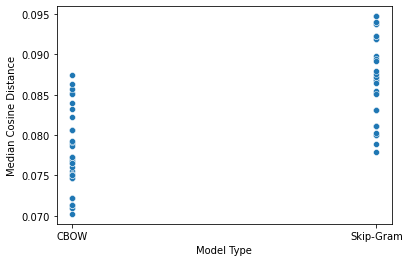

The distance tends to increase along with the Min Count


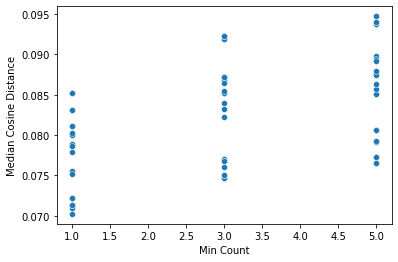

Window Size didn't have relevant effects in the experiments conducted


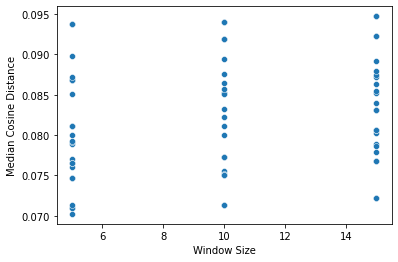

Removing stop words is slightly better


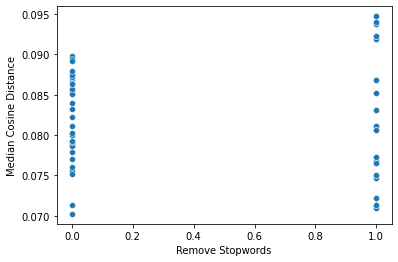

Contraction Expansion didn't have relevant effects in the experiments conducted


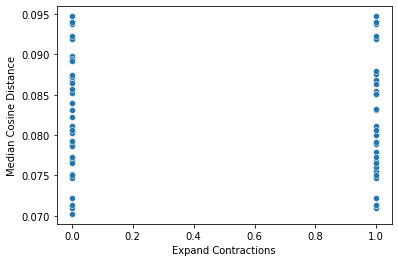

In [75]:
print("CBOW is slightly better")
sns.scatterplot(x='Model Type', y='Median Cosine Distance', data=df)
plt.show()

print("The distance tends to increase along with the Min Count")
sns.scatterplot(x='Min Count', y='Median Cosine Distance', data=df)
plt.show()

print("Window Size didn't have relevant effects in the experiments conducted")
sns.scatterplot(x='Window Size', y='Median Cosine Distance', data=df)
plt.show()

print("Removing stop words is slightly better")
sns.scatterplot(x='Remove Stopwords', y='Median Cosine Distance', data=df)
plt.show()

print("Contraction Expansion didn't have relevant effects in the experiments conducted")
sns.scatterplot(x='Expand Contractions', y='Median Cosine Distance', data=df)
plt.show()